In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM
***

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# I decided to import this library because it handles months instead of just weeks
# Which is important for a general function that can take leap days into account
# (even though it's not strictly necessary for our use case)
from dateutil.relativedelta import relativedelta as rd

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base_ = automap_base()
# reflect the tables
base_.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
base_.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measure_ = base_.classes.measurement
station_ = base_.classes.station

In [8]:
# Create our session (link) from Python to the DB

sess = Session(engine)

# Exploratory Precipitation Analysis
***

In [9]:
sess.query(measure_).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x13b98e650>,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08,
 'tobs': 65.0}

In [10]:
sess.query(station_).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x13b9acc90>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [11]:
# Find the most recent date in the data set.
date_latest = dt.datetime.strptime(sess.query(measure_.date).order_by(measure_.date.desc()).first().date, '%Y-%m-%d')
date_latest
# Since the dates are ordered YYYY-MM-DD, it does not matter whether or not we convert it to datetime.
# Definitely want to watch out for potential issues on other date formats, though.

datetime.datetime(2017, 8, 23, 0, 0)

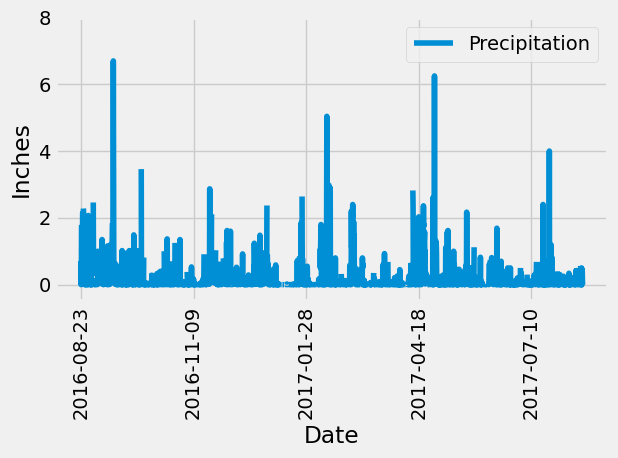

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year behind the last date in data set.
# Making a general function is tricky, There hasn't been a leap day in the past year in this situation, but we do not know that for the general case
dstr_1yr_back = dt.date.strftime(date_latest - rd(months=12), '%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
prcp_past_1yr = sess.query(measure_.date, measure_.prcp).filter(measure_.date >= dstr_1yr_back).order_by(measure_.date.desc())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
df_prcp_1yr = pd.DataFrame(prcp_past_1yr).rename(columns={'date': 'Date', 'prcp': 'Precipitation'}).set_index('Date').sort_index(ascending=True)

df_prcp_1yr.head()

# Use Pandas Plotting with Matplotlib to plot the data

df_prcp_1yr.plot(kind='line', ylim=[-0.5, 8])
plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

# I could mess with the xticks but I'm gonna call this good enough.

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_prcp_1yr.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis
***

In [14]:
# Design a query to calculate the total number of stations in the dataset
sess.query(station_.station).count()


9

In [15]:
sess.query(measure_).group_by(measure_.station).count()

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = sess.query(measure_.station, func.count(measure_.station)).group_by(measure_.station).order_by(func.count(measure_.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sess.query(func.min(measure_.tobs).label('min'), func.max(measure_.tobs).label('max'), func.avg(measure_.tobs).label('avg')).filter(measure_.station == station_activity[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

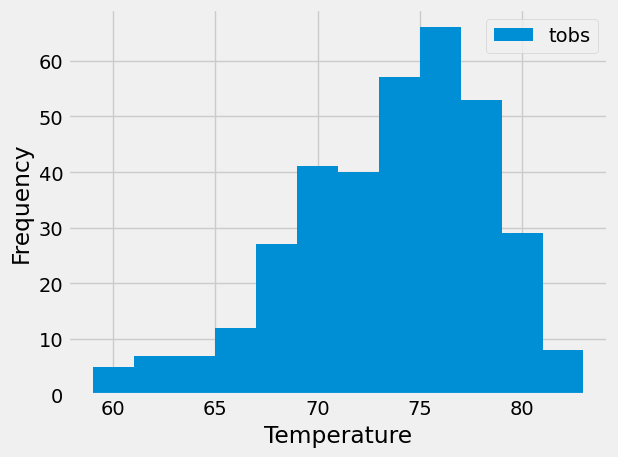

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_past_1yr = sess.query(measure_.date, measure_.tobs).filter(measure_.date >= dstr_1yr_back, measure_.station == station_activity[0][0]).order_by(measure_.date)

# Use Pandas Plotting with Matplotlib to plot the data
df_tobs_1yr = pd.DataFrame(tobs_past_1yr).sort_values('tobs', ascending=True)

df_tobs_1yr.head()

df_tobs_1yr['tobs'].plot(kind='hist', bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

# Close Session

In [19]:
# Close Session
sess.close()